# Exploratory Data Analysis
By Yiting Mao

Mathematics Department, Imperial College London

In this jupyter notebook, I will do the **Exploratory Data Analysis** to the Dataset used in this M4R project ([the arXiv Dataset](https://www.kaggle.com/datasets/Cornell-University/arxiv)).

In [1]:
!pip install kaggle
!pip install 'fsspec>=0.3.3'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 6.8 MB/s 


In [4]:
import tensorflow as tf
import torch
import json
import dask.bag as db
import pandas as pd
import numpy as np
import altair as alt
from sklearn.preprocessing import MultiLabelBinarizer
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import jieba as jb
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.Load arXiv Dataset

In [4]:
token = {"username":"karinmao","key":"0145306b9df944a40f90e51f15167f9c"}
with open('/content/kaggle.json','w') as file:
  json.dump(token,file)

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle datasets download -d Cornell-University/arxiv
!unzip -uq "/content/datasets/Cornell-University/arxiv/arxiv.zip" -d "/content/datasets/Cornell-University/arxiv"

- path is now set to: /content
 99% 1.04G/1.05G [00:37<00:00, 32.2MB/s]
100% 1.05G/1.05G [00:37<00:00, 29.7MB/s]


In [6]:
# load data
docs = db.read_text('/content/datasets/Cornell-University/arxiv/arxiv-metadata-oai-snapshot.json').map(json.loads)

## 2. Exploratory Data Analysis

In [ ]:
# number of samples in the dataset :  2075742 
docs.count().compute()

2075742

In [ ]:
# Example document
docs.take(1)

({'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with data from the Fermilab Tevatron, and predictions are made for\nmore detailed tests with CDF and DO data. Predictions are shown for\ndistributions of diphoton pairs produced at the energy of the Large Hadron\nCollider (LHC). Distributions of the diphoton pairs from the decay of a Higgs\nboson are contrasted with those produced from QCD processes at the LHC, showing\nthat enhanced sensitivity to the signal can be obtained with judicious\nselection 

In [ ]:
# Top Submitters
docs.map(lambda x: x['submitter']).frequencies(sort = True).topk(10, key=1).compute()

[(None, 15189),
 ('EPTCS', 3285),
 ('The CMS Collaboration', 783),
 ('Atlas Publications', 622),
 ('The ATLAS Collaboration', 432),
 ('Delfim F. M. Torres', 403),
 ('EDA Publishing Association', 391),
 ('Cms Collaboration', 373),
 ('Wei Wang', 302),
 ('Scientific Information Service CERN', 287)]

In [ ]:
# Top Authors
parse_authors = trim = lambda x: [' '.join(a).strip() for a in x['authors_parsed']]
docs.map(parse_authors).flatten().frequencies(sort = True).topk(20, key=1).compute()

[('Zhang Y.', 2000),
 ('Wang J.', 1406),
 ('Wang Y.', 1373),
 ('Li Y.', 1291),
 ('Zhang L.', 1217),
 ('Gao Y.', 1180),
 ('CMS Collaboration', 1120),
 ('Liu X.', 1104),
 ('Liu Yang', 1045),
 ('Wang Wei', 1041),
 ('Wang Z.', 1039),
 ('Yang Z.', 1035),
 ('Taniguchi Takashi', 994),
 ('ATLAS Collaboration', 992),
 ('Watanabe Kenji', 956),
 ('Sun L.', 937),
 ('Xu Z.', 911),
 ('Eidelman S.', 890),
 ('Krokovny P.', 883),
 ('Williams M.', 878)]

In [ ]:
# Submissions by datetime
get_latest_version = lambda x: x['versions'][-1]['created']

dates = (docs
         .map(get_latest_version)
         .frequencies(sort = True))

# show top submissions datetime
(dates.topk(10, key=1)
      .compute())

# convert to dataframe 
dates = dates.to_dataframe(columns = ['submission_datetime','submissions']).compute()
dates.head(4)

,submission_datetime,submissions
0,"Wed, 27 Jun 2012 19:59:59 GMT",103
1,"Tue, 14 Feb 2012 16:41:17 GMT",82
2,"Thu, 15 Mar 2012 11:17:56 GMT",78
3,"Sun, 1 Dec 2002 00:00:00 GMT",35


In [ ]:
extract_latest_version = lambda x:x['versions'][-1]["created"] ## Here -1 indicates the last element in the versions. 
extract_latest_version_year = lambda x:x['versions'][-1]["created"].split(" ")[3]

In [ ]:
pub_by_year = docs.map(extract_latest_version_year).frequencies().to_dataframe(columns=['submission_year','num_submissions']).compute()

In [ ]:
pub_by_year=pub_by_year.sort_values(by="submission_year")
pub_by_year.head()

,submission_year,num_submissions
35,1986,1
33,1988,1
34,1989,5
31,1990,24
32,1991,340


In [ ]:
px.line(x='submission_year',y='num_submissions',data_frame=pub_by_year,title="Distribution of Paper Published on Arxiv By Year")

Take the samples from 2021.

In [7]:
# define target year
year = 2021

# Submissions by datetime
get_year = lambda x: x['versions'][-1]['created'].split(' ')[3]

# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract']}

# filter for papers published on or after ????-01-01
docs_df = (docs.filter(lambda x: int(get_year(x)) > (year-1))
               .filter(lambda x: int(get_year(x)) < (year+1))
               .map(trim)
               .compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

# add general category. we are going to use as our target variable
docs_df['general_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x])

In [16]:
docs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202612 entries, 0 to 202611
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                202612 non-null  object
 1   title             202612 non-null  object
 2   category          202612 non-null  object
 3   abstract          202612 non-null  object
 4   general_category  202612 non-null  object
 5   main_category     202612 non-null  object
 6   main_category2    202612 non-null  object
 7   cut               202612 non-null  object
 8   cut2              202612 non-null  object
dtypes: object(9)
memory usage: 13.9+ MB


In [8]:
# add main category
docs_df['main_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x][0].split())

# add main category 2 
docs_df['main_category2'] = docs_df.main_category.apply(lambda x: x[0])

d = {'cat':docs_df['main_category2'].value_counts().index, 'count': docs_df['main_category2'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)

Text(0.5, 1.0, 'year = 2021')

<Figure size 4320x720 with 0 Axes>

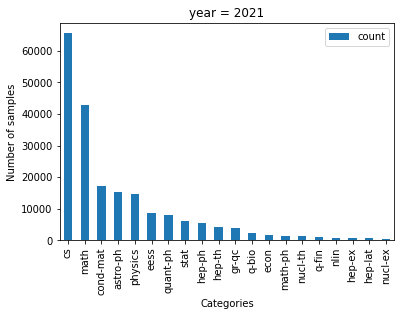

In [9]:
# plot samples - categories
fig = plt.figure(figsize=(60,10))
df_cat.plot('cat','count',kind='bar')
plt.xlabel('Categories')
plt.ylabel('Number of samples')
plt.title('year = %s'%(year))

In [10]:
# remove patterns
pattern = u'[\\s\\d,.<>/?:;\'\"[\\]{}()\\|~!\t"@#$%^&*\\-_=+\n《》、？：；“”‘’｛}（）…￥！—┄－]+'
docs_df['cut'] = (docs_df['abstract']
                    .apply(lambda x: str(x))
                    .apply(lambda x: re.sub(pattern, ' ', x)))
# define stopwords
stopwords = nltk.corpus.stopwords.words("english")

# remove stopwords
docs_df['cut2'] = docs_df['cut'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.666 seconds.
Prefix dict has been built successfully.


In [29]:
docs_df.head(2)

,id,title,category,abstract,general_category,main_category,main_category2,cut,cut2
0,0704.0479,The affine part of the Picard scheme,"[math.AG, math.KT]",We describe the maximal torus and maximal un...,"[math, math]",[math],math,We describe the maximal torus and maximal uni...,We describe maximal torus maxima...
1,0705.4060,C*- Algebras and Thermodynamic Formalism,"[math.DS, math.OA]",We present a detailed exposition (for a Dyna...,"[math, math]",[math],math,We present a detailed exposition for a Dynami...,We present detailed exposition ...


In [35]:
docs_df.iloc[3].abstract

'  We describe details of the renormalization of two-loop integrals relevant to\nthe calculation of the nucleon mass in the framework of manifestly\nLorentz-invariant chiral perturbation theory using infrared renormalization. It\nis shown that the renormalization can be performed while preserving all\nrelevant symmetries, in particular chiral symmetry, and that renormalized\ndiagrams respect the standard power counting rules. As an application we\ncalculate the chiral expansion of the nucleon mass to order O(q^6).\n'

In [36]:
docs_df.iloc[3].cut2

'  We   describe   details       renormalization     two   loop   integrals   relevant       calculation       nucleon   mass       framework     manifestly   Lorentz   invariant   chiral   perturbation   theory   using   infrared   renormalization   It     shown       renormalization       performed     preserving     relevant   symmetries     particular   chiral   symmetry       renormalized   diagrams   respect     standard   power   counting   rules   As     application     calculate     chiral   expansion       nucleon   mass     order   O   q  '

In [11]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(docs_df.general_category)

In [12]:
# concatenate with the abstracts
df = pd.concat([docs_df[['cut2','title']], pd.DataFrame(labels)], axis=1)
df.columns = ['abstract','title'] + list(mlb.classes_)

In [13]:
# sample and keep columns that have at least 1 positive example
sample_df = df.sample(frac = 1, random_state = 4)
keep = sample_df.iloc[:,2:].apply(sum) > 1
sample_df = pd.concat([sample_df.iloc[:,:2],sample_df.iloc[:,2:].iloc[:,keep.values]], axis = 1)

categories = sample_df.columns[2:]

# removed categories
print('Removed following categories from training : {}'.format(str(keep[~keep].index.to_list())))

Removed following categories from training : []


In [20]:
sample_pca = sample_df.loc[sample_df.iloc[:,2:].apply(sum, axis=1) == 1,:].sample(n = 15_000, random_state = 4)
tr = TfidfVectorizer(max_features = 1000, stop_words=stop_words).fit_transform(sample_pca.abstract).todense()
# tfidf = tr.fit_transform(docs_df['cut2']).toarray()
pca = PCA(n_components=2).fit(tr)
data2D = pd.DataFrame(pca.transform(tr), columns = ['PC1','PC2'])
# get categories for abstracts
color = sample_pca.iloc[:,2:].apply(lambda x: x.index[x>0][0], axis = 1)
data2D['category'] = color.to_list()
alt.data_transformers.disable_max_rows()
# plot scatter plot 
alt.Chart(data2D).mark_circle(size=15).encode(
    x=alt.X('PC1', axis = None),
    y=alt.Y('PC2', axis = None),
    color = 'category'
).properties(
    title='First 2 Principal Components of the submissions in year 2021',
    width = 600,
    height = 600
).configure_axis(
    grid=False
).configure_view(strokeOpacity=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


alt.Chart(...)

## References:
1. [Kaggle - EDA and Multi Label Classification for arXiv](https://www.kaggle.com/code/kobakhit/eda-and-multi-label-classification-for-arxiv)
2. [Exploring ArXiv Using Dask](https://www.kaggle.com/code/aiswaryaramachandran/exploring-arxiv-using-dask/notebook)